In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 5.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b5a90404fcf820cbbe865e49c93eeda58f45ea84d3987e5bb43ab2f4392cad96
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


Make sure you create a kaggle API key. Please visit this link for more details


https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab




In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c prudential-life-insurance-assessment

  0% 0.00/3.24M [00:00<?, ?B/s]
100% 3.24M/3.24M [00:00<00:00, 184MB/s]


In [ ]:
!unzip prudential-life-insurance-assessment.zip -d .

Archive:  prudential-life-insurance-assessment.zip
  inflating: ./sample_submission.csv.zip  
  inflating: ./test.csv.zip          
  inflating: ./train.csv.zip         


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("train.csv.zip")
df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0.0,3,NaN,1,2,6,3,1,2,1,1,1,3,1,0.000667,1,1,2,2,NaN,0.598039,NaN,0.526786,4.0,112,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,0.131799,0.272288,0.000,1,3,0.0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133,1,3,2,2,0.188406,NaN,0.084507,NaN,5.0,412,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,0.288703,0.428780,0.030,9,1,0.0,2,0.0300,1,2,8,3,1,1,1,2,1,1,3,NaN,3,2,3,3,0.304348,NaN,0.225352,NaN,10.0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0.0,3,0.2000,2,2,8,3,1,2,1,2,1,1,3,NaN,3,2,3,3,0.420290,NaN,0.352113,NaN,0.0,350,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,0.234310,0.424046,0.027,9,1,0.0,2,0.0500,1,2,6,3,1,2,1,2,1,1,3,NaN,3,2,3,2,0.463768,NaN,0.408451,NaN,NaN,162,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8


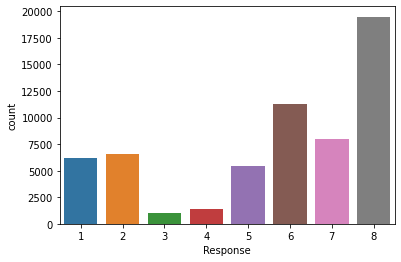

In [ ]:
sns.countplot(x = 'Response', data=df)

We can clearly see that data is highly skewed. That needs to change because PyTorch supports labels starting from 0.

In [ ]:
class2idx = {
    1:0,
    2:1,
    3:2,
    4:3,
    5:4,
    6:5,
    7:6,
    8:7
}

idx2class = {v: k for k, v in class2idx.items()}

df['Response'].replace(class2idx, inplace=True)

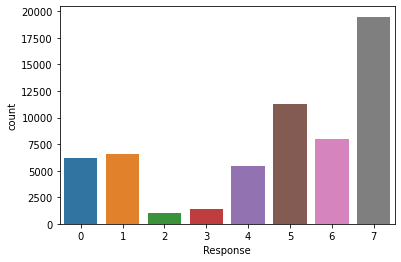

In [ ]:
sns.countplot(x = 'Response', data=df)

In [ ]:
def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [ ]:
#missing_percentage(train)
missing_percentage(df)

,Total,Percent
Medical_History_10,58824,99.06
Medical_History_32,58274,98.14
Medical_History_24,55580,93.60
Medical_History_15,44596,75.10
Family_Hist_5,41811,70.41
Family_Hist_3,34241,57.66
Family_Hist_2,28656,48.26
Insurance_History_5,25396,42.77
Family_Hist_4,19184,32.31
Employment_Info_6,10854,18.28


So we can see that we have a lot of missing data. Interesting.

In [ ]:
# missing values treatment

df['Medical_History_1'].fillna(0, inplace=True)
df['Medical_History_10'].fillna(0, inplace=True)
df['Medical_History_15'].fillna(0, inplace=True)
df['Medical_History_24'].fillna(0, inplace=True)
df['Medical_History_32'].fillna(0, inplace=True)

In [ ]:
df['Family_Hist_2'].fillna(df['Family_Hist_3'].mean(), inplace=True)
df['Family_Hist_3'].fillna(df['Family_Hist_3'].mean(), inplace=True)
df['Family_Hist_4'].fillna(df['Family_Hist_3'].mean(), inplace=True)
df['Family_Hist_5'].fillna(df['Family_Hist_3'].mean(), inplace=True)

In [ ]:
df['Employment_Info_1'].fillna(df['Employment_Info_1'].mean(), inplace=True)
df['Employment_Info_4'].fillna(df['Employment_Info_4'].mean(), inplace=True)
df['Employment_Info_6'].fillna(df['Employment_Info_6'].mean(), inplace=True)

In [ ]:
df['Insurance_History_5'].fillna(df['Insurance_History_5'].mean(), inplace=True)

In [ ]:
missing_percentage(df)

,Total,Percent


In [ ]:
categorical=['Product_Info_1', 'Product_Info_2', 'Product_Info_3', 'Product_Info_5', 'Product_Info_6', 'Product_Info_7', 
             'Employment_Info_2', 'Employment_Info_3', 'Employment_Info_5', 'InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 
             'InsuredInfo_4', 'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7', 'Insurance_History_1', 'Insurance_History_2', 
             'Insurance_History_3', 'Insurance_History_4', 'Insurance_History_7', 'Insurance_History_8', 'Insurance_History_9', 
             'Family_Hist_1', 'Medical_History_2', 'Medical_History_3', 'Medical_History_4', 'Medical_History_5', 'Medical_History_6', 
             'Medical_History_7', 'Medical_History_8', 'Medical_History_9', 'Medical_History_11', 'Medical_History_12', 
             'Medical_History_13', 'Medical_History_14', 'Medical_History_16', 'Medical_History_17', 'Medical_History_18', 
             'Medical_History_19', 'Medical_History_20', 'Medical_History_21', 'Medical_History_22', 'Medical_History_23', 
             'Medical_History_25', 'Medical_History_26', 'Medical_History_27', 'Medical_History_28', 'Medical_History_29', 
             'Medical_History_30', 'Medical_History_31', 'Medical_History_33', 'Medical_History_34', 'Medical_History_35', 
             'Medical_History_36', 'Medical_History_37', 'Medical_History_38', 'Medical_History_39', 
             'Medical_History_40', 'Medical_History_41']
## Creating dummy variable 
final_features = pd.get_dummies(df, columns=categorical).reset_index(drop=True)
final_features.shape

(59381, 897)

In [ ]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 95.0:
            overfit.append(i)
    overfit = list(overfit)
    return overfit


overfitted_features = overfit_reducer(final_features)

final_features = final_features.drop(overfitted_features, axis=1)

In [ ]:
new_cols = [col for col in final_features.columns if col != 'Response'] + ['Response']
final_features = final_features[new_cols]
final_features

,Id,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_15,Medical_History_24,Medical_Keyword_11,Medical_Keyword_15,Medical_Keyword_23,Medical_Keyword_25,Medical_Keyword_37,Medical_Keyword_40,Medical_Keyword_48,Product_Info_2_A8,Product_Info_2_D1,Product_Info_2_D2,Product_Info_2_D3,Product_Info_2_D4,Product_Info_3_10,Product_Info_3_26,Product_Info_6_1,Product_Info_6_3,Employment_Info_2_1,Employment_Info_2_9,Employment_Info_2_12,Employment_Info_2_14,Employment_Info_3_1,Employment_Info_3_3,Employment_Info_5_2,...,Medical_History_4_2,Medical_History_6_1,Medical_History_6_3,Medical_History_8_2,Medical_History_8_3,Medical_History_9_1,Medical_History_9_2,Medical_History_12_2,Medical_History_12_3,Medical_History_13_1,Medical_History_13_3,Medical_History_16_1,Medical_History_16_3,Medical_History_18_1,Medical_History_18_2,Medical_History_21_1,Medical_History_21_2,Medical_History_23_1,Medical_History_23_3,Medical_History_25_1,Medical_History_25_2,Medical_History_26_2,Medical_History_26_3,Medical_History_28_1,Medical_History_28_2,Medical_History_29_1,Medical_History_29_3,Medical_History_33_1,Medical_History_33_3,Medical_History_34_1,Medical_History_34_3,Medical_History_36_2,Medical_History_36_3,Medical_History_37_1,Medical_History_37_2,Medical_History_39_1,Medical_History_39_3,Medical_History_41_1,Medical_History_41_3,Response
0,2,0.076923,0.641791,0.581818,0.148536,0.323008,0.028,0.000000,0.361469,0.000667,0.497737,0.598039,0.497737,0.526786,4.0,240.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,...,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,7
1,5,0.076923,0.059701,0.600000,0.131799,0.272288,0.000,0.000000,0.001800,0.000133,0.188406,0.497737,0.084507,0.497737,5.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,1,...,0,0,1,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,3
2,6,0.076923,0.029851,0.745455,0.288703,0.428780,0.030,0.000000,0.030000,0.001733,0.304348,0.497737,0.225352,0.497737,10.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,...,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,7
3,7,0.487179,0.164179,0.672727,0.205021,0.352438,0.042,0.000000,0.200000,0.001733,0.420290,0.497737,0.352113,0.497737,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,...,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,1,0,7
4,8,0.230769,0.417910,0.654545,0.234310,0.424046,0.027,0.000000,0.050000,0.001733,0.463768,0.497737,0.408451,0.497737,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,...,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,0.230769,0.074627,0.709091,0.320084,0.519103,0.020,0.000000,0.025000,0.001733,0.217391,0.497737,0.197183,0.497737,0.0,32.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,...,0,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1,3
59377,79143,0.230769,0.432836,0.800000,0.403766,0.551119,0.100,0.000010,0.350000,0.000267,0.565217,0.497737,0.478873,0.497737,24.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,1,...,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,6
59378,79144,0.076923,0.104478,0.745455,0.246862,0.360969,0.035,0.000000,0.361469,0.001733,0.173913,0.497737,0.126761,0.497737,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,1,...,1,0,1,1,0,0,1,1,0,0,1,1,0,1,0,1,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,0,1,0,1,1,0,7
59379,79145,0.230769,0.507463,0.690909,0.276151,0.462452,0.038,0.006283,0.361469

In [ ]:
final_features.to_csv('final_features.csv')

In [ ]:
!git clone https://github.com/theainerd/comp-insurance.git

Cloning into 'comp'...
remote: Enumerating objects: 25, done.
remote: Total 25 (delta 0), reused 0 (delta 0), pack-reused 25
Unpacking objects: 100% (25/25), done.


In [ ]:
cd comp

/content/comp


In [ ]:
!python demo.py

Epoch 0/14
----------
Epoch 000: | Train Loss: 2.08 | Val Loss: 2.09 | Train Acc: 12.74| Val Acc: 18.308
Epoch 1/14
----------
Epoch 001: | Train Loss: 2.08 | Val Loss: 2.13 | Train Acc: 10.42| Val Acc: 35.101
Epoch 2/14
----------
Epoch 002: | Train Loss: 2.07 | Val Loss: 2.19 | Train Acc: 9.06| Val Acc: 37.353
Epoch 3/14
----------
Epoch 003: | Train Loss: 2.07 | Val Loss: 2.24 | Train Acc: 8.79| Val Acc: 38.426
Epoch 4/14
----------
Epoch 004: | Train Loss: 2.07 | Val Loss: 2.26 | Train Acc: 8.62| Val Acc: 39.583
Epoch 5/14
----------
Epoch 005: | Train Loss: 2.06 | Val Loss: 2.28 | Train Acc: 8.61| Val Acc: 40.236
Epoch 6/14
----------
Epoch 006: | Train Loss: 2.06 | Val Loss: 2.29 | Train Acc: 8.30| Val Acc: 40.657
Epoch 7/14
----------
Epoch 007: | Train Loss: 2.06 | Val Loss: 2.31 | Train Acc: 8.06| Val Acc: 40.846
Epoch 8/14
----------
Epoch 008: | Train Loss: 2.06 | Val Loss: 2.30 | Train Acc: 7.89| Val Acc: 41.372
Epoch 9/14
----------
Epoch 009: | Train Loss: 2.06 | Val Loss